# Experiment: XGB Boost AZ encoding

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
DATA_DIR = Path("data/").resolve()

EXPERIMENT_NAME = "03_xgboost-smoothing-param-01"

EXPERIMENT_DIR = Path(f"experiments/{EXPERIMENT_NAME}").resolve()

os.makedirs(EXPERIMENT_DIR, exist_ok=True)

In [3]:
training_set = pd.read_csv(DATA_DIR / "training_set.csv", delimiter=",")

training_set_back = training_set.copy()

# Fix outliers. Looks like an error in data entry

training_set.loc[training_set.D3D > 10000, "D3D"] = training_set.D3D / 1000
training_set.loc[training_set.D2D > 10000, "D2D"] = training_set.D2D / 1000
training_set.loc[training_set.AZ > 1000, "AZ"] = training_set.AZ / 1000

In [4]:
features_to_drop = ["ID_FILA", "ID_EVENTO"]

In [5]:
categorical_features = [
    "CAMPO",
    "FLUIDO",
    "HIJO",
    "PAD_HIJO",
    "PADRE",
    "ESTADO",
    "LINEAMIENTO"
]

### Target Encoding + Additive smoothing

In [6]:
smooth_means = {}

In [7]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Store the smoothed mean for each value of `by`
    smooth_means[smooth.index.name] = smooth.to_dict()

In [8]:
for c in categorical_features:
    calc_smooth_mean(training_set, by=c, on='delta_WHP', m=1500)

### Preprocessing

In [9]:
from typing import Any, Dict, List

def preprocessing(df: pd.DataFrame, categorical_features: List[str], smooth_means: Dict[str, Any]) -> pd.DataFrame:
    df = df.drop(labels=features_to_drop, axis=1)

    df["AZ_sin"] = df["AZ"].transform(lambda x: np.sin(x * (np.pi / 180)))
    df["AZ_cos"] = df["AZ"].transform(lambda x: np.cos(x * (np.pi / 180)))

    df = df.drop(labels=["AZ"], axis=1)

    for c in categorical_features:
        df[c] = df[c].map(smooth_means[c])

    return df

In [10]:
training_set = preprocessing(training_set, categorical_features, smooth_means)

### XGB Regressor

In [11]:
df_train = training_set.sample(frac=0.75)
df_test = training_set[~training_set.index.isin(df_train.index)]

len(df_train), len(df_test)

(19634, 6544)

In [12]:
TARGET = "delta_WHP"

X_train = df_train.drop(TARGET, axis=1)
y_train = df_train[TARGET]

X_test = df_test.drop(TARGET, axis=1)
y_test = df_test[TARGET]

In [13]:
reg = xgb.XGBRegressor(
    booster="gbtree",
    n_estimators=5000,
    objective="reg:squarederror",
    early_stopping_rounds=50,
    learning_rate=0.1,
)

In [14]:
reg.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=20,
)

[0]	validation_0-rmse:7.14297	validation_1-rmse:7.86347
[20]	validation_0-rmse:4.42409	validation_1-rmse:6.19956
[40]	validation_0-rmse:3.76283	validation_1-rmse:6.05879
[60]	validation_0-rmse:3.38747	validation_1-rmse:6.02256
[80]	validation_0-rmse:3.09905	validation_1-rmse:6.01166
[100]	validation_0-rmse:2.84681	validation_1-rmse:6.00598
[120]	validation_0-rmse:2.69526	validation_1-rmse:6.01606
[133]	validation_0-rmse:2.55950	validation_1-rmse:6.01246


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=5000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [15]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=["importance"]
).sort_values("importance", ascending=False)

fi.head()

,importance
HIJO,0.151811
D3D,0.134406
PAD_HIJO,0.078210
PADRE,0.073326
AZ_cos,0.072353


## Predictions

### Pre-process preds set

In [16]:
predictions_set = pd.read_csv(DATA_DIR / "predictions_set.csv", delimiter=",")

predictions_set_back = predictions_set.copy()

def predictions_preprocessing(df: pd.DataFrame) -> pd.DataFrame:

    df["D3D"] = df["D3D"].transform(lambda d: d.replace(",", "."))
    df["D3D"] = df["D3D"].astype(float)

    df["WHP_i"] = df["WHP_i"].transform(lambda d: d.replace(",", "."))
    df["WHP_i"] = df["WHP_i"].astype(float)

    df = preprocessing(df, categorical_features, smooth_means)

    return df

In [17]:
predictions_set = predictions_preprocessing(predictions_set)

### Make predictions

In [18]:
predictions_set["delta_WHP"] = reg.predict(predictions_set)

## Understand predictions

### Target

In [19]:
training_set.loc[:, "delta_WHP"].describe(percentiles=[.001, .05, .1, .25, .5, .75, .9, .95, .97, .999])

count    26178.000000
mean         1.375667
std          7.573975
min        -90.000000
0.1%        -8.364600
5%           0.000000
10%          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          1.100000
95%          7.100000
97%         13.200000
99.9%      101.069900
max        212.800000
Name: delta_WHP, dtype: float64

In [20]:
pd.DataFrame(
    data=[
        training_set.loc[:, "delta_WHP"].describe(percentiles=[.001, .05, .1, .25, .5, .75, .9, .95, .97, .999]),
        predictions_set.loc[:, "delta_WHP"].describe(percentiles=[.001, .05, .1, .25, .5, .75, .9, .95, .97, .999]),
    ],
    index=pd.MultiIndex.from_tuples([
        ("Training", "delta_WHP"),
        ("Predictions", "delta_WHP"),
    ], names=("set", "feature"))
)

,,count,mean,std,min,0.1%,5%,10%,25%,50%,75%,90%,95%,97%,99.9%,max
set,feature,,,,,,,,,,,,,,,
Training,delta_WHP,26178.0,1.375667,7.573975,-90.00000,-8.364600,0.00000,0.000000,0.000000,0.000000,0.00000,1.100000,7.100000,13.200000,101.069900,212.800000
Predictions,delta_WHP,6537.0,1.290851,4.817982,-28.10891,-1.557293,-0.09183,-0.040522,-0.021145,0.041022,0.40659,2.666239,6.670956,12.902947,53.382359,81.115982


Text(0.5, 1.0, 'Dist. of delta_WHP in predictions')

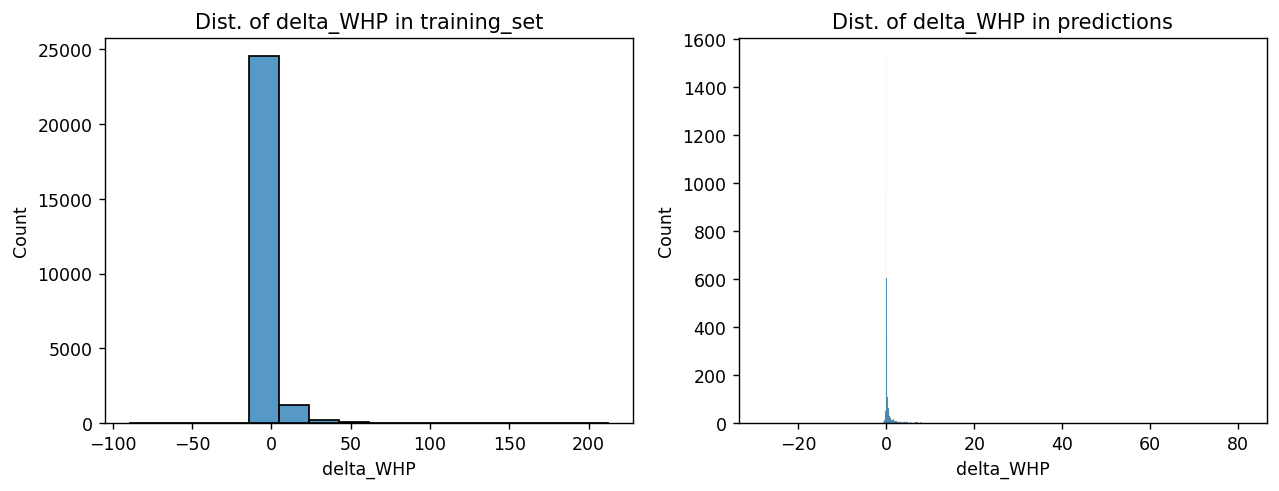

In [21]:
fig, axs = plt.subplots(ncols=2, **{"figsize": (12, 4), "dpi": 125, "facecolor": "white"})

sns.histplot(data=training_set, x="delta_WHP", ax=axs[0]).set_title("Dist. of delta_WHP in training_set")
sns.histplot(data=predictions_set, x="delta_WHP", ax=axs[1]).set_title("Dist. of delta_WHP in predictions")

### Target according to distances

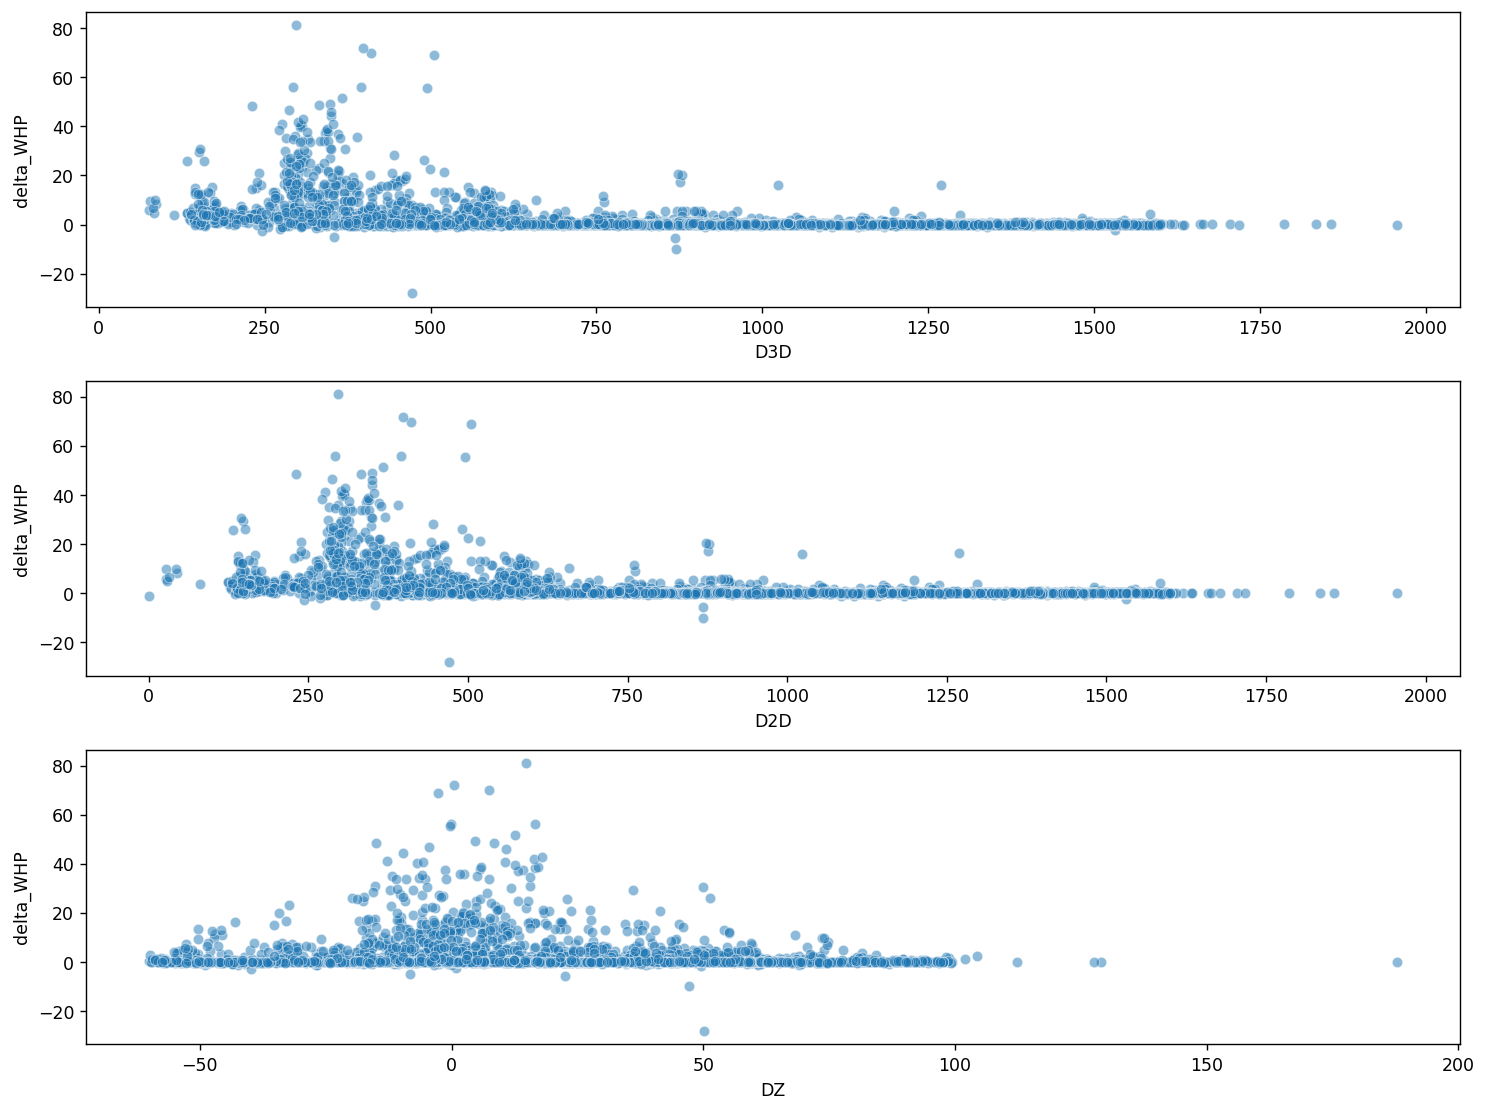

In [27]:
fig, axs = plt.subplots(nrows=3, **{"figsize": (12, 9), "dpi": 125, "facecolor": "white"})

sns.scatterplot(x='D3D', y='delta_WHP',data=predictions_set[predictions_set.D3D < 9000], ax=axs[0], alpha=0.5)
sns.scatterplot(x='D2D', y='delta_WHP', data=predictions_set, ax=axs[1], alpha=0.5)
sns.scatterplot(x='DZ',y='delta_WHP', data=predictions_set, ax=axs[2], alpha=0.5)

plt.tight_layout()

### Target according to barriers

<AxesSubplot:xlabel='#_BARRERAS', ylabel='delta_WHP'>

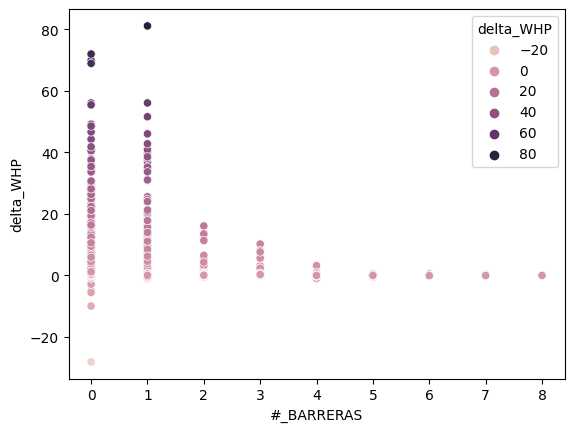

In [28]:
sns.scatterplot(
    data=predictions_set,
    x="#_BARRERAS",
    y="delta_WHP", hue="delta_WHP"
)

### Target according to AZ

<AxesSubplot:xlabel='AZ_cos', ylabel='AZ_sin'>

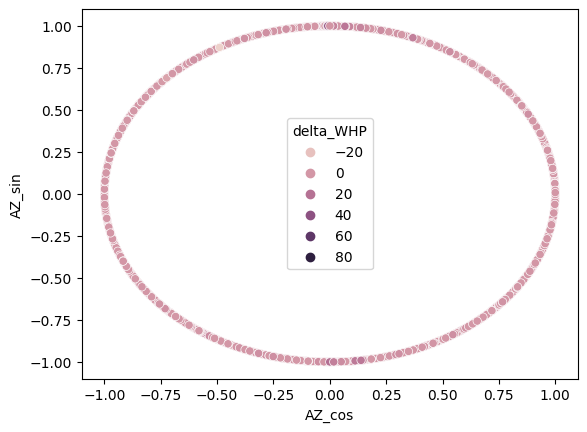

In [29]:
sns.scatterplot(
    data=predictions_set,
    x="AZ_cos",
    y="AZ_sin", hue="delta_WHP"
)

## Submit answer

In [25]:
raise

RuntimeError: No active exception to reraise

In [30]:
predictions_set = pd.concat([predictions_set_back, predictions_set["delta_WHP"]], axis=1)

In [31]:
predictions_set.to_csv(
    EXPERIMENT_DIR / "predicciones.csv",
    columns=["ID_FILA", "delta_WHP"],
    header=False,
    index=False,
)

In [32]:
reg.save_model(EXPERIMENT_DIR / "xgb-model")